# Описание проекта

Распознавание актантов глагола - это проект, направленный на создание эффективного алгоритма классификации токенов для распознавания актантов внутри текстов на русском языке. Основная цель проекта - распознавание действующих лиц в текстах различной направленности (публицистической, художественной, новостной).

- [Статья по проекту](https://drive.google.com/file/d/15FLmWjsvs7qW9joj-QByUw7C-rH0LMeI/view)


## Business understanding

Существует необходимость в парсере актантов глаголов. В идеале в конце нужно получить алгоритм извлечения и отображения действующих лиц из поданного текста.

## Data understanding

Для решения задачи требовалось найти более или менее подходящий набор текстов с IOB-tagging разметкой. Разметка была произведена вручную поверх текстов (Fenogenova et.al. 2024). После этого тексты были извлечены и организованы в json-файл.

## Baseline
Бейслайн для текущей задачи следует выбирать исходя из сути задачи классификации токенов - формат возвращаемых данных = массив, эквивалентный по длине получаемому массиву

### Метрики
В качестве основных метрик оценки используются Accuracy, Precision, F1 и Recall. В нашем случае Accuracy отражает число всех правильно выделенных меток. Precision - это доля выделенных актантов. Recall - сколько актантов из числа всех актантов в тексте действительно было выделено.

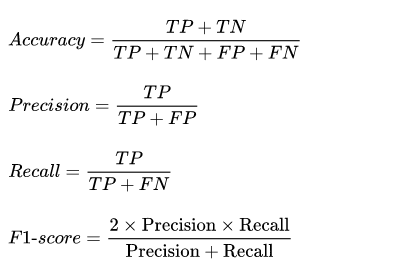

## Подход через LLM

В качестве "подопытных" моделей мы выбрали малоразмерные модели из семейства BERT, в том числе ruBert-base, rubert-tiny2 и ruRuberta-large.

Основная часть работы была сосредоточена вокруг того, чтобы подобрать эффективные параметры при имеющемся количестве данных. Лучшие варианты того, как выглядела тенденция метрик у всех трех моделей, представлена на рисунке ниже.

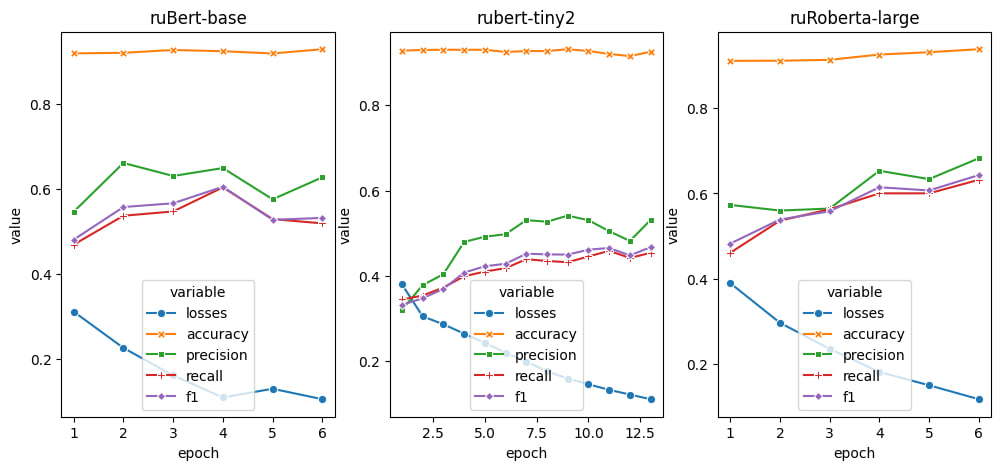

А вот какие результаты удалось получить по части метрик:

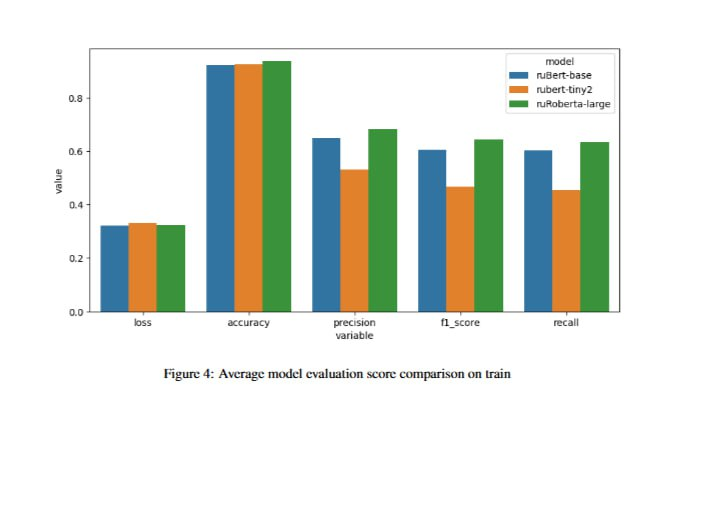

Результаты были получены с такой настройкой параметров модели. В остальные параметры изменений не вносилось, но вероятно планируется.

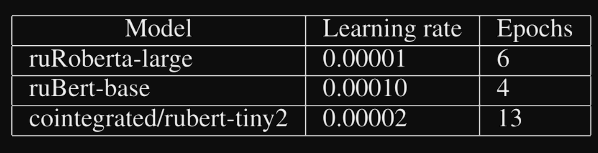

# Импорты

## pip install

In [ ]:
!pip install datasets -q
!pip install pymorphy2 -q
!pip install -U pymorphy2-dicts-ru
!pip install razdel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## import

In [ ]:
from gensim.models.word2vec import Word2Vec
from gensim.models.fasttext import FastText
import gensim.downloader as download_api
import pymorphy2

In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset, DatasetDict
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from transformers import AutoModelForTokenClassification, AutoTokenizer, TrainingArguments, Trainer
import transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from datasets import Dataset, DatasetDict
from transformers import TrainingArguments, Trainer
import numpy as np
import sys
import requests
from tqdm import tqdm
import sklearn

In [ ]:
import os
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
import torch.optim as optim
from sklearn.metrics import average_precision_score, precision_score, accuracy_score, balanced_accuracy_score
from torch.utils.data import DataLoader
import re
import string
all_strings = list(string.punctuation)
all_strings.extend(['.', '»', '«', '“', '”', '‘', '’', '–', '–', '—', '…', '—'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from razdel import tokenize, sentenize

In [ ]:
import random

# Загрузка файла json
Открываем файл для работы. Получаем список словарей **data**, в каждом из которых под ключом ["text"] находятся собственно тексты, а под ключом ["actants"] - список действующих лиц в тексте. Тексты имеют различное содержание, в том числе:
- Новостные статьи
- Стихотворения

In [ ]:
with open(os.path.join('actants_final.json'), 'r', encoding='utf-8') as f:
    data = json.load(f)

In [ ]:
def regex_clean(text: str) -> str:
  regex = r'([!\"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~\s]\s)+([!\"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~\s]\s)+'
  regex_links = r'http\S+[a-z]'
  text = re.sub(regex, '', text)
  text = re.sub(regex_links, '', text)
  text = re.sub(r'\*\s\*\s\*\s\`\s', '', text)
  substitutions = [('\\n\\n', ' '), ('  ', ' '), ('  ', ' '), ("( ", "("), (" )", ")"), (" \n", " "), ("\n ", " "), ("* * * `", "")]
  for i, sub in enumerate(substitutions):
    text = text.replace(sub[0], sub[1])
  text = text.strip()
  text = text.strip('* * * ` ')
  return text

def clean_data(d):
  d['text'] = regex_clean(d['text'])
  return d

In [ ]:
_data = [clean_data(n) for n in data]

In [ ]:
"""Пример стихотворного текста"""
_data[154]

{'text': 'Завёлся озорник у нас. Горюет вся семья. В квартире от его проказ Буквально нет житьяНикто с ним, правда, не знаком, Но знают все зато, Что виноват всегда во всём Лишь он один — НИКТОКто, например, залез в буфет, Конфеты там нашёл И все бумажки от конфет Кто побросал под стол? Кто на обоях рисовал? Кто разорвал пальто? Кто в папин стол свой нос совал? НИКТО, НИКТО, НИКТО — НИКТО — ужасный сорванец! Сказала строго мать.Его должны мы наконец Примерно наказать! НИКТО сегодня не пойдёт Ни в гости, ни в киноСмеётесь вы? А нам с сестрой Ни капли не смешно!',
 'actants': ['озорник', 'семья', 'мать', 'сестрой', 'рассказчик', 'читатели']}

In [ ]:
"""Пример новостного текста"""
_data[25]

{'text': 'Россияне стали больше переживать из-за коррупции, расслоения общества, недоступности образования и медицинского обслуживания, выяснили социологи «Левада-центра». Обеспокоенность коррупцией достигла максимума за все 15 лет исследований центра: 38 процентов респондентов назвали эту проблему наиболее острой. Год назад так ответили 28 процентов опрошенных. Каждый третий участник опроса отметил, что переживает из-за кризиса в экономике и резкого расслоения на богатых и бедных, каждый четвертый — из-за платной медицины и недоступного образования. Больше всего россиян традиционно волнуют проблемы, связанные с материальным благосостоянием. 47 процентов респондентов беспокоятся из-за бедности, 40 процентов — из-за безработицы. Самые большие опасения у опрошенных были по поводу возможного роста цен — так ответили 63 процента респондентов. По сравнению с предыдущими годами этот показатель значительно снизился, например, в начале 2017 года он был 69 процентов, в 2016-м — 77 процентов, а 

In [ ]:
data = _data

# Exploratory Data Analysis

## Характеристики данных
Общее число уникальных текстов в данных - 245, общее число уникальных актантов в них - 1800

### Поисковые функции

In [ ]:
def fetch_by_start(s:str, data=data) -> dict:
  for n in data:
    for key, value in n.items():
      if key == "text" and value.startswith(s):
        return n
  return None

In [ ]:
def fetch_by_re(s:str, data=data) -> dict:
  for n in data:
    for key, value in n.items():
      if key == "text" and re.search(s, value) != None:
        return n
  return None

In [ ]:
def morph_normal_form(word: str, morph=morph):
  p = morph.parse(word)[0].normal_form
  if p != "" and p != None:
    return p
  return word.lower()

def instant_clean(text: str):
  for k in all_strings:
    text = text.replace(k, "")
  return text.lower()

### EDA

In [ ]:
# Число уникальных текстов в данных 245
len(set([n["text"] for n in data]))

245

In [ ]:
# Число уникальных актантов 1800
actants_unique = list()
for n in data:
  actants_unique.extend(n["actants"])
print(len(set(actants_unique)))

1800


In [ ]:
# В среднем мы имеем тексты длиной 150 токенов (floor mean)
texts_clean = [[morph_normal_form(i) for i in instant_clean(n["text"]).split()] for n in data]
cap = np.mean([len(n) for n in texts_clean])
cap

158.33807829181495

In [ ]:
# В среднем по 8 актантов на текст
np.mean([len(n["actants"]) for n in data])

8.138790035587188

В данных присутствуют различные виды текстов: новостные, художественные, публицистические, стихотворения, и т.д.

НОВОСТНОЙ

In [ ]:
fetch_by_re("В сети")

{'text': 'В сети обратили внимание на зеркальное селфи жительницы Луизианы по имени Алиса, которая попыталась похвастаться новым вечерним платьем. «Собираюсь на ужин, чтобы появился повод надеть это», —отметила она под фотографией, опубликованной в ее Twitter-аккаунте. В итоге пост набрал более трех тысяч ретвитов и семи тысяч лайков и вызвал негодование среди пользователей социальной сети, которых возмутило, что девушка сделала фотографию на фоне «ужасного и отвратительного» беспорядка. «Боже мой, вы только посмотрите на эту комнату. Я помолюсь за того, кто на тебе женится», — заявил один из них. «После ужина она будет есть маршмэллоу с пола на десерт» «Это что мышь вот тут?» Некоторые, вдохновившись обстановкой комнаты, принялись вспоминать свое детство. «Когда я смотрю на это, я прямо чувствую, как мама меня бьет», — поделился пользователь с ником Yunglaraa. Другие начали даже самостоятельно «убирать» комнату девушки с помощью фотошопа. «Исправлено», —похвастался Bk17. Сама Алиса ок

НОВОСТНОЙ 2

In [ ]:
fetch_by_re("Глава Минфина предложил")

{'text': 'Глава Минфина предложил "не размазывать" резервные фонды по лишним проектам Министр финансов РФ Антон Силуанов заявил, что увеличивать количество инвестиционных проектов, финансируемых за счет средств Фонда национального благосостояния (ФНБ), неразумно, сообщает ИА "Финмаркет". "Я очень скептически отношусь к проблеме дальнейшего инвестирования средств ФНБ в инвестиционные проекты"сказал Силуанов журналистам в среду. Уже одобренных проектов - строительство высокоскоростной магистрали Москва - Казань, модернизация Транссиба, реконструкция ЦКАД - вполне, по его мнению, достаточно. Стоимость проекта по строительству высокоскоростной железнодорожной магистрали Москва - Казань оценивается в 1-1,2 триллиона рублей. На реализацию проектов по строительству Центральной кольцевой автомобильной дороги и модернизации Транссибирской магистрали, по данным Минфина, потребуется еще 200 миллиардов и 300 миллиардов рублей. Министр пояснил, что эти три проекта были выбраны для максимально эффек

ПУБЛИЦИСТИЧЕСКИЙ

In [ ]:
fetch_by_re("Россияне стали больше")

{'text': 'Россияне стали больше переживать из-за коррупции, расслоения общества, недоступности образования и медицинского обслуживания, выяснили социологи «Левада-центра». Обеспокоенность коррупцией достигла максимума за все 15 лет исследований центра: 38 процентов респондентов назвали эту проблему наиболее острой. Год назад так ответили 28 процентов опрошенных. Каждый третий участник опроса отметил, что переживает из-за кризиса в экономике и резкого расслоения на богатых и бедных, каждый четвертый — из-за платной медицины и недоступного образования. Больше всего россиян традиционно волнуют проблемы, связанные с материальным благосостоянием. 47 процентов респондентов беспокоятся из-за бедности, 40 процентов — из-за безработицы. Самые большие опасения у опрошенных были по поводу возможного роста цен — так ответили 63 процента респондентов. По сравнению с предыдущими годами этот показатель значительно снизился, например, в начале 2017 года он был 69 процентов, в 2016-м — 77 процентов, а 

СТИХОТВОРНЫЙ

In [ ]:
fetch_by_re("У Танюши дел немало")

{'text': 'У Танюши дел немало, У Танюши много дел: Утром брату помогала,— Он с утра конфеты ел. Вот у Тани сколько дела: Таня ела, чай пила, Села, с мамой посидела, Встала, к бабушке пошла. Перед сном сказала маме: — Вы меня разденьте сами, Я устала, не могу, Я вам завтра помогу.',
 'actants': ['Танюши', 'брату', 'мамой', 'бабушке']}

In [ ]:
fetch_by_re("В этом городе будет весна")

{'text': '* * * ` Вениамину Смехову В этом городе будет весна, Подобреют, раскроются люди, с храма старые снимут леса. У Никитских Ворот, как тогда, зазвучит из окон Окуджава, и на сцене Таганки по праву совершится апрельский аншлаг. А на одноименной реке о призвании вспомнит трамвайчик, тайно пущенный солнечный зайчик у девчонки замрет на руке... И мальчишка, пустивший его свои мысли отыщет у Блока – это первой любви поволока в их глазах из нездешних стихов. А в арбатских проулках грачи возвестят о своем возвращенье, и даруют друг другу прощенье все заблудшие в зимней ночи. Неуместным покажется то, что кроилось из ложных амбиций, тени больше не станут по лицам наводить грустных мыслей мостов. И уже не хватает листа констатировать все, что здесь будет, как устала Москва от прелюдий... В этом городе будет весна!',
 'actants': ['Смехову',
  'люди',
  'Окуджава',
  'аншлаг',
  'трамвайчик',
  'солнечный зайчик',
  'девчонки',
  'мальчишка',
  'Блока',
  'грачи',
  'все заблудшие',
  'тени

# BERT Architecture models: Work

## BERT Architecture models: Working loop

### Начало работы
В начале работы устанавливаем количество тестов на 0 для удобства подсчета метрик и результатов

In [ ]:
number_tests = 0

### Run script
Полный скрипт работы с моделью для получения результатов и подсчета метрик

#### Tuning
Выбираем модель и настраиваем подачу данных, количество эпох и learning rate.

In [ ]:
# В целях демонстрации назначу 1 эпоху всем моделям на время презентации
parameters = [
    {
        "lr": 1e-5,
        "epochs": 1 # 9
    },
    {
        "lr": 1e-5,
        "epochs": 3 # 3
    },
    {
        "lr": 1e-5,
        "epochs": 1 # 6
    }
]
"""Параметры подбирались для каждой модели индивидуально, исходя из результатов их обучения на данных."""

'Параметры подбирались для каждой модели индивидуально, исходя из результатов их обучения на данных.'

In [ ]:
models = ["cointegrated/rubert-tiny2",
          "ai-forever/ruRoberta-large",
          "ai-forever/ruBert-base"]

model_selected = 1
model_name = models[model_selected]
try_validation = False
SPLIT_RATIO = 0.9
LEARNING_RATE = parameters[model_selected]["lr"]
NUM_EPOCHS = parameters[model_selected]["epochs"]

tokenizer = AutoTokenizer.from_pretrained(model_name) # грузим токенизатор для model_name
model = AutoModelForTokenClassification.from_pretrained(model_name,
                                             num_labels=3) # грузим модель для model_name

# model.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Logic
Внутренняя логика работы с моделью - функции, токенизация, маскирование

##### Предварительное определение функций

In [ ]:
def remove_punct(word) -> str:
    puncts = list(string.punctuation)
    puncts.append("»")
    puncts.append("«")
    # puncts.extend([])
    for punct in puncts:
        word = word.replace(punct, '')
    return word.lower()

In [ ]:
def find_one_actant(txt: str, actant: str):
    """Возвращает спан - индекс начала и индекс конца"""
    text = [n for n in re.split(r'\s+\s*', txt) if n != ""] # text = [n.lower() for n in text.split()]
    pattern = actant.split() # pattern = [n.lower() for n in actant.split()]
    i = 0
    tmp = []
    # lens = 0
    while i < len(text):
        if remove_punct(text[i]) == remove_punct(pattern[0]):
            # print("Featuring", pattern[0])
            start = i
            end = i
            j = 1
            while j < len(pattern) and (len(text)-1) > (i + j):
                if remove_punct(text[i + j]) == remove_punct(pattern[j]):
                    end = i + j
                # i += 1
                j += 1
            if i+j < len(text):
              if j < len(pattern) and remove_punct(text[i + j]) == remove_punct(pattern[j]):
                end = i + j
            tmp.extend([[start, end]])
        i += 1
    if len(tmp) == 0:
      return -1
    res = tmp[np.argmax(list(map(lambda x: x[1] - x[0], tmp)))]
    #if res[1] - res[0] <= len(pattern)-1:
    #    return -1
    return res

In [ ]:
def validate_a(a: any) -> bool:
  if type(a) != list and a == -1:
    return False
  return True

In [ ]:
def find_all_actants(d):
    text = d['text']
    # text = re.sub("\s\s+", "", text)
    actants = d['actants']
    mask = ['O'] * len([n for n in re.split(r'\s+\s*', text) if n != ""])
    # print("text:")
    # print(text[:50])
    # print("-"*30)
    # print("Word length =", len([n for n in re.split(r'\s+\s*', text) if n != ""]))
    # print("Mask length =", len(mask))
    #print(text)
    for actant in actants:
        # print(actant)
        se = find_one_actant(text, actant)
        # print("Detected span", se)
        if validate_a(se):
          start, end = se
          for i in range(start, end + 1):
                if i == start:
                    mask[i] = 'B-A'
                else:
                    mask[i] = 'I-A'
    # print(len(mask))
    assert len(mask) == len([n for n in re.split(r'\s+\s*', text) if n != ""])
    return mask

In [ ]:
def find_all_actants_with_text(d):
    text = d['text']
    actants = d['actants']
    mask = ['O'] * len(text.split(' '))
    for actant in actants:
#         print(actant)
        se = find_one_actant(text, actant)
        # print(se)
        if validate_a(se):
          start, end = se
          for i in range(start, end + 1):
              if i == start:
                  mask[i] = 'B-A'
              else:
                  mask[i] = 'I-A'
    otp = []
    for i, n in enumerate([n.lower() for n in text.split()]):
      otp.append((n, mask[i]))
    return otp

##### Подготовка модели

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = model.to(device)

##### Предобработка текстов и масок

In [ ]:
texts = [elem['text'] for elem in data]  # List[str]
targets = list(map(find_all_actants, data))  # List[List[str]]
# texts[0] -> 'ПРивет, как дела'
# targets[0] -> ['O', 'B-A', 'I-A']

In [ ]:
preproc_texts = list(map(lambda x: tokenizer([x], return_tensors='pt'), texts))  # List[dict]
# preproc_texts[0] -> {'input_ids': tensor([[1, 2, 3, 4, 5]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

##### Функции предобработки таргетов

In [ ]:
def approve_string(s: str) -> bool:
  """Проверяет наличие пунктуации в качестве единственного символа в элементе"""
  punct = ['.', ' ', '»', '«', '“', '”', '‘', '’', '–', '–', '—', '…'] + list(string.punctuation)
  punct = punct + list(string.digits)
  b = True
  c = 0
  for p in punct:
    if p in s:
      c += 1
  if c > 0 and len(s) <= 1:
    b = False
  elif c > 1:
    b = False
  elif len(s) == 1 and re.search(r"\s", s) != None:
    b = False
  elif s in {" \n", " —"}:
    b = False
  return b

In [ ]:
def check_url_in_string(s: str) -> bool:
  if not approve_string(s) or re.search(r'[A-Za-z]', s) != None:
    return True
  return False

In [ ]:
# оформить функцией. Принимает на вход текст и маску, возвращает возвращает только маску требуемого размера
# def preproc_target(text, mask)
# text <- input
# lbs <- input
def preproc_target(text: str, lbs: list, tokenizer) -> list:
  """Аргумент [0] - текст, Аргумент [1] - список размеченных лейблов для слов текста.
  Аргумент [2] - токенизатор для энкодерной модели. Возвращает список проставленных лейблов для токенов,
  найденных в пределах поданного на вход текста. Этот вывод совместим с моделью."""
  # print("Mask length =", len(lbs))
  # print("Word length =", len([n for n in re.split(r"\s+\s*", text) if n != ""]))
  stop_labels = {"[CLS]", "[SEP]", "<s>", "<e>"}
  labels = []
  cnt = 0
  # punct = ['.'] + list(string.punctuation)
  encoded = tokenizer.encode(text)
  # print('-'*30)
  last_token = ""
  for elem in tokenizer.batch_decode(encoded):
    # print(elem, approve_string(elem))
    if elem in stop_labels:
      # print("--special token--")
      label = 0
    elif elem.startswith('##'):
      # print("--word continue--")
      label = labels[-1]
    elif last_token == "-":
      # print("--word continue--")
      label = labels[-1]
    elif check_url_in_string(elem) and check_url_in_string(last_token):
      # print("--word continue--")
      label = labels[-1]
    elif not approve_string(elem):
      # print("--string not approved--")
      label = 0
    else:
      label = lbs[cnt]
      cnt += 1
      # print("--new word--")
    # print(cnt, "/", len(lbs)-1)
    labels.append(label)
    last_token = elem
  # print(f'token: {elem}, label: {label}')
  return labels

In [ ]:
def preproc_target_rta_new(text: str, lbs: list, tokenizer) -> list:
  punct = ['.', ' ', '»', '”', '‘', '’', '–', '–', '—', '…'] + list(string.punctuation)
  stop_labels = {"[CLS]", "[SEP]", "<s>", "<e>", '</s>'}
  labels = []
  cnt = 0
  encoded = tokenizer.encode(text)
  print('-'*30)
  last_token = ""
  for ind, elem in enumerate(tokenizer.batch_decode(encoded)):
    if elem in stop_labels:
      label = 0
      print("STOP LABEL")
      print('-'*30)
    elif ind == 1:
      label = lbs[cnt]
      print("FIRST TOKEN:", elem, "#", cnt, lbs[cnt])
      # cnt += 1
      print('-'*30)
    elif len(elem) > 1 and " " in elem:
      if last_token != " (":
        cnt += 1
        label = lbs[cnt]
        print("NEW WORD:", elem, "#", cnt, lbs[cnt])
        print('-'*30)
      else:
        label = labels[-1]
        print("WORD CONTINUE", elem, '%', cnt, lbs[cnt])
        print('-'*30)
    elif " " not in elem:
      label = labels[-1]
      print("WORD CONTINUE", elem, '%', cnt, lbs[cnt])
      print('-'*30)
    #elif elem == " ":
     # label = 0
      #print("NOT APPROVED")
      #print('-'*30)
    else:
      cnt += 1
      label = lbs[cnt]
      print("NEW WORD:", elem, "#", cnt, lbs[cnt])
      print('-'*30)
    #print(elem, label)
    #print("token", ind)
    #print("word", cnt)
    labels.append(label)
    last_token = elem
  return labels

##### Предобработка таргетов для модели

In [ ]:
preprocessing_script = [
    preproc_target,
    preproc_target_rta_new
]

preproc = preproc_target

if model_name == models[1]:
  preproc = preprocessing_script[1]

NameError: name 'preproc_target' is not defined

In [ ]:
preproc_targets = []
for i in tqdm(range(len(texts))):
    new_mask = preproc(texts[i], targets[i], tokenizer)
    preproc_targets.append(new_mask)

NameError: name 'texts' is not defined

In [ ]:
assert all([preproc_texts[i]['input_ids'].shape[1] == len(preproc_targets[i]) for i in range(len(texts))])

##### Подготовка к обучению: Сбор датасета

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def convert_my_masks(lb: list[str]) -> torch.tensor:
  convert = {
      "0": 0,
      0: 0,
      "O": 0,
      "B-A": 1,
      "I-A": 2
      }
  return torch.tensor([convert[n] for n in lb])

In [ ]:
from random import randint

In [ ]:
SEED = randint(0, 1000000)

In [ ]:
def split_data(data, train_ration: float):
    train_size = int(train_ration * len(data))
    test_size = len(data) - train_size

    torch.manual_seed(SEED)
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    return train_dataset, test_dataset

In [ ]:
class CustomDataset(Dataset):
	def __init__(self, texts: list, targets: list):
		self.texts = texts
		self.target = targets

	def __len__(self):
		return len(self.texts)

	def __getitem__(self, idx):
		text = self.texts[idx]
		labels = self.target[idx]
		return text, labels

In [ ]:
#dataset = CustomDataset([{k:v for k, v in b.items()} for b in preproc_texts], [convert_my_masks(t) for t in preproc_targets])
dataset = CustomDataset([{k:v.to(device) for k, v in b.items()} for b in preproc_texts], [convert_my_masks(t).to(device) for t in preproc_targets])

In [ ]:
train, test = split_data(dataset, SPLIT_RATIO)
if try_validation:
  train, validation = split_data(train, SPLIT_RATIO)
else:
  validation = test

##### Функции для обучения модели

In [ ]:
if not os.path.isdir("staged_results"):
  os.mkdir("staged_results")

In [ ]:
def name_process(modelname) -> str:
  return modelname.split("/")[1]

In [ ]:
# training
# zip(preproc_texts, preproc_targets)
def train_one_epoch(model, train, validation, epoch):
  losses = []
  f1_train = []
  acc_train = []
  prec_train = []
  rec_train = []
  model.train()
  print("Entering training loop...")
  for batch in tqdm(iter(train)):
      txt, lb = batch
      # lb = convert_my_masks(lb)
      txt_new = {
          'input_ids': txt['input_ids'][:, -512:],
          'attention_mask': txt['attention_mask'][:, -512:]
      }
      lb_new = lb[-512:].to(device)
      out = model(labels=lb_new, **txt_new)
      # Волшебство
      out.loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      # Собираем лоссы
      losses.extend([out.loss.item()])
  model.eval()
  print("Entering validation loop...")
  with torch.no_grad():
    for batch in tqdm(iter(validation)):
        txt, lb = batch
        txt_new = {
            'input_ids': txt['input_ids'][:, -512:],
            'attention_mask': txt['attention_mask'][:, -512:]
        }
        lb_new = lb[-512:].to(device)
        out = model(labels=lb_new, **txt_new)
        # Считаем предикты
        pred = out.logits.squeeze(0).softmax(-1).argmax(-1).to('cpu') # предикты переводим на cpu чтобы нумпай мог их посчитать
        lb_count = lb_new.to('cpu')
        # Собираем метрики
        f1_train.append(f1_score(lb_count, pred, average='macro', zero_division=0.0))
        acc_train.append(accuracy_score(lb_count, pred))
        prec_train.append(precision_score(lb_count, pred, average='macro', zero_division=0.0))
        rec_train.append(recall_score(lb_count, pred, average='macro', zero_division=0.0))
  return model, {"model_name": name_process(model_name), "epoch": epoch, "losses": np.mean(losses), "accuracy": np.mean(acc_train), "precision": np.mean(prec_train), "recall": np.mean(rec_train), "f1": np.mean(f1_train)}

In [ ]:
def write_staged_results(data):
  with open(f"staged_results/{data['epoch']}_{data['model_name']}.json", encoding="utf-8", mode="w") as j:
    j.write(json.dumps(data))
  return

#### Training loop

In [ ]:
# Train model for k epochs
for n in range(0, NUM_EPOCHS):
  print("Итерируется", n+1, "эпоха")
  model, metrics = train_one_epoch(model, train, validation, epoch=n+1)
  print()
  print("-"*30)
  print("Loss:", metrics["losses"])
  print("accuracy:", metrics["accuracy"])
  print("precision:", metrics["precision"])
  print("recall", metrics["recall"])
  print("f1 score", metrics["f1"])
  print("-"*30)
  write_staged_results(metrics)

Итерируется 1 эпоха
Entering training loop...


252it [02:09,  1.94it/s]


Entering validation loop...


29it [00:02, 14.18it/s]



------------------------------
Loss: 0.3895910992508843
accuracy: 0.9114129433706368
precision: 0.6748338000844903
recall 0.56900577380708
f1 score 0.5883430035197805
------------------------------
Итерируется 2 эпоха
Entering training loop...


252it [01:07,  3.72it/s]


Entering validation loop...


29it [00:02, 14.28it/s]



------------------------------
Loss: 0.25084835332300925
accuracy: 0.9282626413462516
precision: 0.7150458679683971
recall 0.6455069066404259
f1 score 0.6537261757532806
------------------------------
Итерируется 3 эпоха
Entering training loop...


252it [01:07,  3.71it/s]


Entering validation loop...


29it [00:02, 14.30it/s]


------------------------------
Loss: 0.1785494683731702
accuracy: 0.9389131566885008
precision: 0.7679464890833311
recall 0.6880287403393461
f1 score 0.6974634458282382
------------------------------


#### Оценка модели

In [ ]:
# test
model.eval()
# лоссы
losses = []
# метрики
f1 = []
acc = []
prec = []
rec = []
# предикты модели
test_texts = [] # Тексты для тестирования
model_predictions = [] # предикты модели
lbs_for_test = [] # лейблы теструемых текстов

with torch.no_grad():
    for batch in iter(test):
        txt, lb = batch
        txt_new = {
          'input_ids': txt['input_ids'][:, -512:],
          'attention_mask': txt['attention_mask'][:, -512:]
        }
        lb_new = lb[-512:].to(device)
        # lb = convert_my_masks(lb)
        out = model(labels=lb_new, **txt_new)
        losses.append(out.loss.item())
        pred = out.logits.squeeze(0).softmax(-1).argmax(-1).to('cpu')
        model_predictions.append(pred)
        lb_new = lb_new.to('cpu')
        lbs_for_test.append(lb_new)
        test_texts.append(txt_new["input_ids"])
        f1.append(f1_score(lb_new, pred, average='macro', zero_division=0.0))
        acc.append(accuracy_score(lb_new, pred))
        prec.append(precision_score(lb_new, pred, average='macro', zero_division=0.0))
        rec.append(recall_score(lb_new, pred, average='macro', zero_division=0.0))

#### Проверка совпадения токенов с актантами (Work in progress)

In [ ]:
def clean_restored_text(s: list[str]) -> str:
  """Очищает текст от специальных токенов"""
  text = s[0]
  special_tokens = ['<s>', '</s>']
  for n in special_tokens:
    text = re.sub(n, '', text)
  return text

In [ ]:
def actants_data(text):
  """Проверяет, что текст есть в наших данных и возвращает список актантов"""
  for n in data:
    for key, value in n.items():
      if key == 'text' and value == text:
        return n['actants']
  return False

# check_if_in_data(clean_restored_text(tokenizer.batch_decode(test_texts[0])))

In [ ]:
def actants_reconstruct(text, actants):
    mask = ['O'] * len([n for n in re.split(r'\s+\s*', text) if n != ""])
    for actant in actants:
        # print(actant)
        se = find_one_actant(text, actant)
        # print("Detected span", se)
        if validate_a(se):
          start, end = se
          for i in range(start, end + 1):
                if i == start:
                    mask[i] = 'B-A'
                else:
                    mask[i] = 'I-A'
    # print(len(mask))
    assert len(mask) == len([n for n in re.split(r'\s+\s*', text) if n != ""])
    return mask

In [ ]:
def smart_substitute(word, token) -> str:
  new_token = ""
  escape = "\ "
  for n in token:
    if not re.search(r"[A-Za-z0-9]", n):
      new_token += escape[0]
    new_token += n
  word = re.sub(new_token, "", word)
  return word

In [ ]:
def present_text(text: str, lst: list[tuple[str]]) -> list[str]:
  """TODO"""
  # Разделить text на токены по пробелам
  # Для каждого токена создать маску из списков со строками ['O', 'O'] по его длине
  # Для каждого токена сделать алгоритм проверки на вхождение разбитых токенов
  words = re.split("\s+", text)
  shattered_tokens = []
  shattered_true = []
  shattered_pred = []
  for n in lst:
    shattered_tokens.append(n[0])
    shattered_true.append(n[1])
    shattered_pred.append(n[2])
  current_token = 0
  word_masks = [["O", "O"] for word in words]
  for i, word in enumerate(words):
    current_mask = "O"
    current_mask_predict = current_mask
    if current_token+1 < len(shattered_tokens):
      for j, token in enumerate(shattered_tokens[current_token:]):
        j += current_token
        current_token += 1
        token = token.strip()
        if token in word:
          print(word, token)
          word = smart_substitute(word, token)
          if j < len(shattered_true):
            current_mask = shattered_true[j]
            current_mask_predict = shattered_pred[j]
        else:
          print("token not in word")
        if len(word) < 1:
          word_masks[i] = [current_mask, current_mask_predict]
          break
  return list(zip(words, word_masks))

In [ ]:
def reconstruct_text(elem) -> str:
  """Функция реконструирует текст из инпутов. На вход получаем тензор, который разворачиваем обратно в текст"""
  reconst = tokenizer.batch_decode(elem)
  reconst = clean_restored_text(reconst)
  return reconst, actants_data(reconst)

def reconstruct_tags(tag) -> str:
  tags_dictionary = {
    "O": "O",
    "B-A": "B-A",
    "I-A": "I-A",
    0: "O",
    1: "B-A",
    2: "I-A"
  }
  return tags_dictionary[tag]

# Задача - превратить тексты из токенизированных фрагментов в целостный текст, подобный изначальным текстам в наших данных
for i, n in enumerate(test_texts):
  """Сделаем прогон по тестовым текстам и пройдемся по ним функцией, которая их восстановит TODO"""
  text, actants = reconstruct_text(n)
  if actants != False:
    encoded = tokenizer.encode(text)
    decoded = tokenizer.batch_decode(encoded)
    predictions_check = []
    for j, k in enumerate(preproc_target_rta_new(text, actants_reconstruct(text, actants), tokenizer)):
      predictions_check.append((decoded[j], reconstruct_tags(k), reconstruct_tags(model_predictions[i].numpy()[j])))
    predictions_check = present_text(text, predictions_check)
    for n in predictions_check:
      print(n)

  # TODO

Выходные данные были обрезаны до нескольких последних строк (5000).
NEW WORD:  ев # 106 O
------------------------------
WORD CONTINUE роп % 106 O
------------------------------
WORD CONTINUE ы % 106 O
------------------------------
NEW WORD:  и # 107 O
------------------------------
NEW WORD:  ст # 108 O
------------------------------
WORD CONTINUE рас % 108 O
------------------------------
WORD CONTINUE бург % 108 O
------------------------------
WORD CONTINUE ского % 108 O
------------------------------
NEW WORD:  суда # 109 O
------------------------------
WORD CONTINUE . % 109 O
------------------------------
NEW WORD:  Свое # 110 O
------------------------------
NEW WORD:  выступление # 111 O
------------------------------
NEW WORD:  в # 112 O
------------------------------
NEW WORD:  пас # 113 O
------------------------------
WORD CONTINUE е % 113 O
------------------------------
NEW WORD:  ч # 114 O
------------------------------
WORD CONTINUE ав % 114 O
-----------------------

##### Экспорт результатов

In [ ]:
fashionable_results_1 = {
    "num_epochs": NUM_EPOCHS,
    "split_ratio": SPLIT_RATIO,
    "learning_rate": LEARNING_RATE,
    "test_loss": losses,
    "acc": acc,
    "prec": prec,
    "f1": f1,
    'rec': rec,
    "seed": SEED
}

In [ ]:
with open(f"results_{number_tests}_{name_process(model_name)}.json", encoding="utf-8", mode="w") as j:
  j.write(json.dumps(fashionable_results_1))

#### Results

In [ ]:
with open(f"results_{number_tests}_{name_process(model_name)}.json", encoding="utf-8", mode="r") as j:
  d = json.loads(j.read())

In [ ]:
print("Seed:", d["seed"])

Seed: 448201


In [ ]:
np.mean(d["prec"])

0.7679464890833311

In [ ]:
number_tests += 1

In [ ]:
our_text = [
    ('Новый', ['O', 'O']),
    ('глава', ['O', 'O']),
    ('парламентской', ['O', 'O']),
    ('ассамблеи', ['O', 'I-A']),
    ('совета', ['O', 'I-A']),
    ('европы', ['O', 'O']),
    ('(пасе)', ['O', 'O']),
    ('мевлют', ['B-A', 'B-A']),
    ('чавушоглу', ['O', 'O']),
    ('начал', ['O', 'O']),
    ('свое', ['O', 'O']),
    ('первое', ['O', 'O']),
    ('выступление', ['O', 'O']),
    ('перед', ['O', 'O']),
    ('парламентариями', ['I-A', 'I-A']),
    ('ассамблеи', ['O', 'O']),
    ('с', ['O', 'O']),
    ('благодарности', ['O', 'O']),
    ('своей', ['O', 'O']),
    ('семье,', ['O', 'O']),
    ('передает', ['O', 'O']),
    ('корреспондент', ['B-A', 'B-A']),
    ('риа', ['I-A', 'I-A']),
    ('новости.', ['O', 'O']),

]

In [ ]:
pd.DataFrame({
    "word": [n[0] for n in our_text],
    "masked_token": [n[1][0] for n in our_text],
    "predicted_token": [n[1][1] for n in our_text]
}).to_csv("mytable.csv")

In [ ]:
def find_all_actants_pd(d):
    text = d['text']
    # text = re.sub("\s\s+", "", text)
    actants = d['actants']
    text_split = [n for n in re.split(r'\s+\s*', text) if n != ""]
    mask = ['O'] * len(text_split)
    for actant in actants:
        # print(actant)
        se = find_one_actant(text, actant)
        # print("Detected span", se)
        if validate_a(se):
          start, end = se
          for i in range(start, end + 1):
                if i == start:
                    mask[i] = 'B-A'
                else:
                    mask[i] = 'I-A'
    # print(len(mask))
    assert len(mask) == len(text_split)
    return pd.DataFrame({"text": text_split, "mask": mask})

In [ ]:
find_all_actants_pd(data[1])[20:30].to_csv("my_table.csv")

## Обработка json вывода

In [ ]:
for n in ["results", "staged_results"]:
  if not os.path.isdir(n):
    os.mkdir(n)

In [ ]:
for root, dirs, files in os.walk("results"):
  for f in files:
    os.remove(os.path.join(root, f))

In [ ]:
def open_my_json(_file) -> dict:
  return json.loads(_file)

def fetch_jsons():
  for root, dirs, files in os.walk("results"):
    return [os.path.join(root, n) for n in files]

def strip_regex(s: str) -> str:
  s = re.sub(r"results/results_\d+_", "", s)
  s = s.strip(".json")
  return s

def open_my_jsons(lst: list):
  json_dicts = []
  for n in lst:
    with open(n, encoding="utf-8", mode="r") as f:
      d = open_my_json(f.read())
      d["model_name"] = strip_regex(n)
      json_dicts.append(d)
  return json_dicts

In [ ]:
my_jsons = open_my_jsons(fetch_jsons())

In [ ]:
my_staged_results = []
for root, dirs, files in os.walk("staged_results"):
  for filename in files:
    with open(os.path.join(root, filename), encoding="utf-8", mode="r") as f:
      my_staged_results.append(json.loads(f.read()))

In [ ]:
compress_staged_results = dict()
for n in my_staged_results:
  for key in n.keys():
    if key not in compress_staged_results.keys():
      compress_staged_results[key] = list()
  for key, value in n.items():
    compress_staged_results[key].append(value)

In [ ]:
compress_staged_results['model_name']

['ruRoberta-large',
 'ruRoberta-large',
 'ruRoberta-large',
 'ruRoberta-large',
 'ruRoberta-large',
 'ruRoberta-large']

In [ ]:
new_df = pd.DataFrame({
    "model": [n["model_name"] for n in my_jsons],
    "accuracy": [np.mean(n["acc"]) for n in my_jsons],
    "precision": [np.mean(n["prec"]) for n in my_jsons],
    "recall": [np.mean(n["rec"]) for n in my_jsons],
    "f1": [np.mean(n["f1"]) for n in my_jsons],
    "learning rate": [n["learning_rate"] for n in my_jsons],
    "epochs": [n["num_epochs"] for n in my_jsons]
})

In [ ]:
# new_df.to_csv("new_statistics.csv", encoding="utf-8")

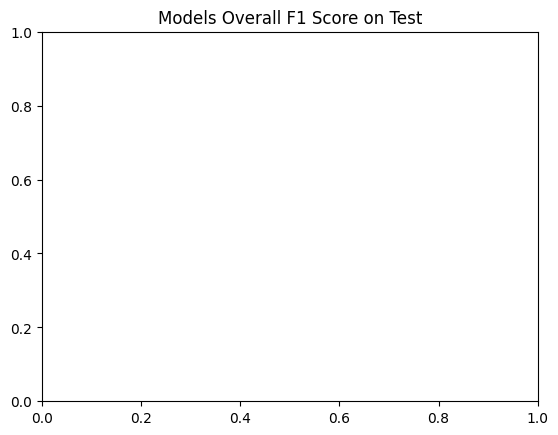

In [ ]:
# plot distplot
metric_observed = 'f1'

fig, ax = plt.subplots()
sns.barplot(data=new_df,
            hue='model',
            y=metric_observed,
            palette='tab10',
            ax=ax)

# change the limits of X-axis
ax.set_ylim(0.0, 1.0)
plt.title(f'Models Overall {metric_observed.capitalize()} Score on Test')
plt.show()

In [ ]:
staged_df = pd.DataFrame(compress_staged_results)
staged_df

,model_name,epoch,losses,accuracy,precision,recall,f1
0,ruRoberta-large,5,0.049140,0.922592,0.751135,0.682326,0.697417
1,ruRoberta-large,6,0.037265,0.923081,0.753210,0.690922,0.705668
2,ruRoberta-large,3,0.113066,0.912225,0.731011,0.735282,0.712415
3,ruRoberta-large,2,0.190626,0.914646,0.730308,0.647925,0.657302
4,ruRoberta-large,4,0.068722,0.920441,0.742205,0.725100,0.715470
5,ruRoberta-large,1,0.350651,0.904136,0.683621,0.637756,0.640700


In [ ]:
epochs = list(set(staged_df["epoch"]))
epochs.sort()
models = list(set(staged_df["model_name"]))
model_stat = models[2]
stat_model_loss = []
stat_model_acc = []
stat_model_prec = []
stat_model_rec = []
stat_model_f1 = []
for n in epochs:
  for i in my_staged_results:
    if i["epoch"] == n and i["model_name"] == model_stat:
      stat_model_loss.append(i["losses"])
      stat_model_acc.append(i["accuracy"])
      stat_model_prec.append(i["precision"])
      stat_model_rec.append(i["recall"])
      stat_model_f1.append(i["f1"])

# Начинаем
fig, ax = plt.subplots()
new_df_staged = pd.DataFrame({
    'epochs': epochs,
    'losses': stat_model_loss,
    'accuracy': stat_model_acc,
    'precision': stat_model_prec,
    'recall': stat_model_rec,
    'f1': stat_model_f1
}
)
new_staged_datas = []
for i, s in new_df_staged.iterrows():
  metrics = []
  metrics.extend([s["losses"], s["accuracy"], s["precision"], s["recall"], s["f1"]])
  metric = ["losses", "accuracy", "precision", "recall", "f1"]
  epoch_array = [s["epochs"] for i in metrics]
  new_staged_datas.append(pd.DataFrame(
      {
          "metric": metric,
          'metrics': metrics,
          'epoch': epoch_array
      }
  ))
for data_pak in new_staged_datas:
  sns.barplot(data=data_pak,
                x='epoch',
                y='metrics',
                hue="metric",
                palette='tab10',
                ax=ax)
# Логика внизу не позволяет выйти за пределы меток в легенде
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:5], labels[:5])
# Задаем лимит по оси y
ax.set_ylim(0.0, 1.0)
# Задаем заголовок
plt.title(f'{model_stat} Performance on Train')
# Вы продаёте рыбов?
plt.show()

IndexError: list index out of range

In [ ]:
#
fig, ax = plt.subplots()
metric = ["losses", "accuracy", "precision", "recall", "f1"]
metric_observed = metric[4]
individual_plots = {
    "epoch": [],
    "model_name": [],
    metric_observed: []
}
model_names_chart = set(staged_df["model_name"])

for model_name_chart in model_names_chart:
  for i in epochs:
    for index, row in staged_df.iterrows():
      if row["model_name"] == model_name_chart and row["epoch"] == i:
        individual_plots["epoch"].append(i)
        individual_plots["model_name"].append(row["model_name"])
        individual_plots[metric_observed].append(row[metric_observed])

sns.barplot(
    data=pd.DataFrame(individual_plots),
    x='epoch',
    y=metric_observed,
    hue='model_name',
    palette='tab10',
    ax=ax
  )
# Логика внизу не позволяет выйти за пределы меток в легенде
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:3], labels[:3])
# Задаем лимит по оси y
ax.set_ylim(0.0, 1.0)
# Задаем заголовок
plt.title(f'Overall Performance on Train ({metric_observed})')
# Вы продаёте рыбов? Нет, а что, красивое?
plt.show()

In [ ]:
model_performance_prec = [(n["model_name"], n["rec"]) for n in my_jsons]
y = np.vstack([n[1] for n in model_performance_prec])
fig, ax = plt.subplots()
ax.stackplot(range(len(y[0])), y, labels=[n[0] for n in model_performance_prec])
plt.legend(loc='upper right')
ax.set_title("Models recall")
plt.show()

In [ ]:
new_df.to_csv("output.csv", encoding="utf-8")

## Comments

In [ ]:
for batch in test:
  txt, lb = batch
  break

In [ ]:
txt1 = {
    'input_ids': txt['input_ids'][:, -512:].to(device),  # можно вообще всегда брать последние 512 токенов. Если их меньше, то возьмутся все, ошибки не выпадет
    'attention_mask': txt['attention_mask'][:, -512:].to(device),
    'token_type_ids': txt['token_type_ids'][:, -512:].to(device),
}
lb1 = lb[-512:].to(device)

In [ ]:
out = model(labels=lb1, **txt1)

In [ ]:
out.loss.item()  # это кросс-энтропия модели на данном тексте с данными лейблами, она нулевая из-за того, что все лайблы - нули

In [ ]:
predictions = out.logits.squeeze(0).log_softmax(-1).argmax(-1)  # это то, что модель предсказала (метка класса для каждого токена инпута)
probas = out.logits.squeeze(0).softmax(-1).max(-1).values

In [ ]:
# убираем таргеты и предикты с видеокарты и переводим в нумпай
tgt = lb1.detach().cpu().numpy()
pred = predictions.detach().cpu().numpy()
probs = probas.detach().cpu().numpy()  # а это вероятности для выбранных моделью токенов, можно тоже метрики считать по ним

In [ ]:
acc = sklearn.metrics.accuracy_score(tgt, pred)
precision = sklearn.metrics.precision_score(tgt, pred, average='macro')
recall = sklearn.metrics.recall_score(tgt, pred, average='macro')
f1 = sklearn.metrics.f1_score(tgt, pred, average='macro')
# roc_auc = sklearn.metrics.roc_auc_score(tgt, probs, average='macro')  # когда починишь лейблы таргета, можно будет почекать рок аук метрику

In [ ]:
np.mean(f1)

In [ ]:
np.mean(acc)

In [ ]:
np.mean(prec)

In [ ]:
np.mean(rec)

In [ ]:
plt.hist(f1)

In [ ]:
plt.hist(acc)

In [ ]:
plt.hist(prec)

In [ ]:
plt.hist(rec)

Кусок для объединения разрозненных json

In [ ]:
import os
import json

In [ ]:
only_json = list(filter(lambda x: 'json' in x, os.listdir('.')))

In [ ]:
test_files = list(filter(lambda x: x.startswith('results'), only_json))

In [ ]:
train_files = list(filter(lambda x: not x.startswith('results'), only_json))

In [ ]:
def read_json(path):
    with open(path, encoding='utf-8') as f:
        data = json.load(f)
    return data

def write_json(path, obj):
    with open(path, 'w', encoding='utf-8') as f:
      json.dump(obj, f, ensure_ascii=False, indent=4)

In [ ]:
train_json = [read_json(elem) for elem in train_files]

In [ ]:
test_json = [read_json(elem) for elem in test_files]

In [ ]:
test_json = [dict(**{'model': test_files[i].split('.json')[0].split('_')[-1]}, **test_json[i]) for i in range(len(test_json))]

In [ ]:
write_json('./train.json', train_json)

In [ ]:
write_json('./test.json', test_json)

Рисуем

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec as gs

In [ ]:
train = pd.DataFrame(train_json)

In [ ]:
train_new = pd.melt(train, id_vars=['model_name', 'epoch'], value_vars=['losses', 'accuracy', 'precision', 'recall', 'f1'])

In [ ]:
train_new.head(3)

In [ ]:
fig = plt.figure(figsize=(12, 5))
grid = gs(1, 3, figure=fig)
for idx, model in enumerate(train_new['model_name'].unique()):
    sub = train_new[train_new['model_name'] == model]
    ax = fig.add_subplot(grid[idx])
    sns.lineplot(data=sub, x='epoch', y='value', hue='variable', markers=True, dashes=False, style="variable")
    plt.title(model)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 10))
grid = gs(2, 2, figure=fig)
for idx, feature in enumerate(set(train_new['variable'].unique()) - {'losses'}):
    sub = train_new[train_new['variable'] == feature]
    ax = fig.add_subplot(grid[idx // 2, idx % 2])
    sns.lineplot(data=sub, x='epoch', y='value', hue='model_name', markers=True, dashes=False, style="model_name")
    plt.title(feature)
plt.show()

In [ ]:
test = pd.DataFrame(test_json)

In [ ]:
test[['test_loss', 'acc', 'prec', 'f1', 'rec']].apply(lambda x: x.apply(lambda y: np.mean(y)), axis=1).rename({'test_loss': 'loss', 'acc': 'accuracy', 'prec': 'precision', 'f1': 'f1_score', 'rec': 'recall'}, axis=1)

In [ ]:
test_new = pd.concat([
    test['model'],
    (test[['test_loss', 'acc', 'prec', 'f1', 'rec']]
     .apply(lambda x: x.apply(lambda y: np.mean(y)), axis=1)
     .rename({'test_loss': 'loss', 'acc': 'accuracy', 'prec': 'precision', 'f1': 'f1_score', 'rec': 'recall'}, axis=1))
], axis=1)

In [ ]:
test_new = pd.melt(test_new, id_vars=['model'], value_vars=['loss', 'accuracy', 'precision', 'f1_score', 'recall'])

In [ ]:
test_new

In [ ]:
sns.catplot(
    test_new, kind="bar",
    x="variable", y="value", col="model",
    palette='tab10',  aspect=.8,
)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=test_new, x='variable', y='value', hue='model', palette='tab10')
plt.show()